In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

(2351, 25)
(486, 25)
Glucose                                      0.121786
Cholesterol                                  0.023058
Hemoglobin                                   0.944893
Platelets                                    0.905372
White Blood Cells                            0.507711
Red Blood Cells                              0.403033
Hematocrit                                   0.164216
Mean Corpuscular Volume                      0.307553
Mean Corpuscular Hemoglobin                  0.207938
Mean Corpuscular Hemoglobin Concentration    0.505562
Insulin                                      0.571162
BMI                                          0.839271
Systolic Blood Pressure                      0.580903
Diastolic Blood Pressure                     0.556037
Triglycerides                                0.477742
HbA1c                                         0.85681
LDL Cholesterol                              0.652465
HDL Cholesterol                              0.106961
ALT    

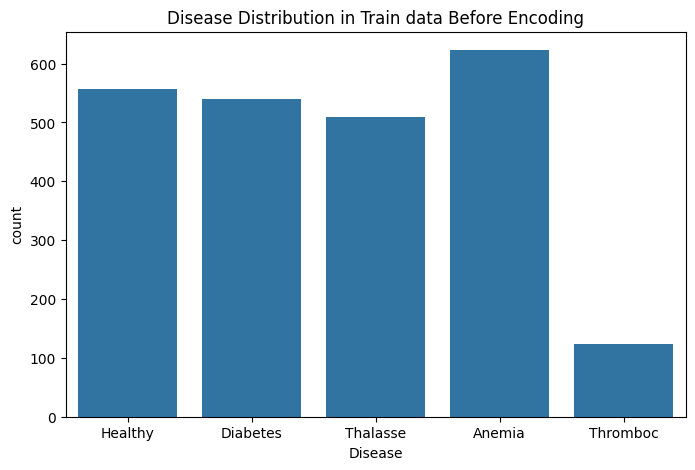

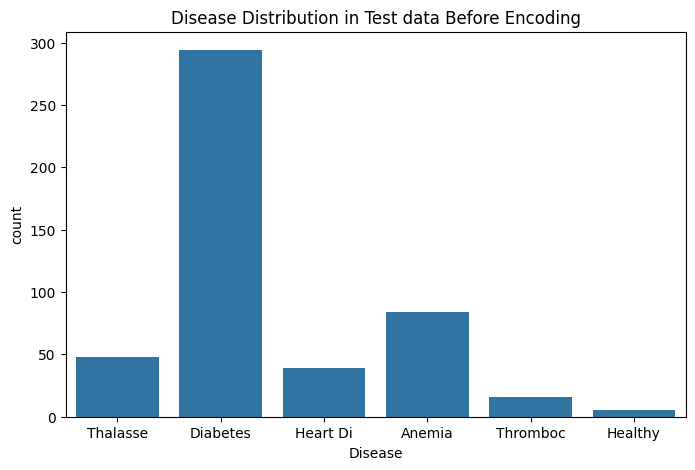

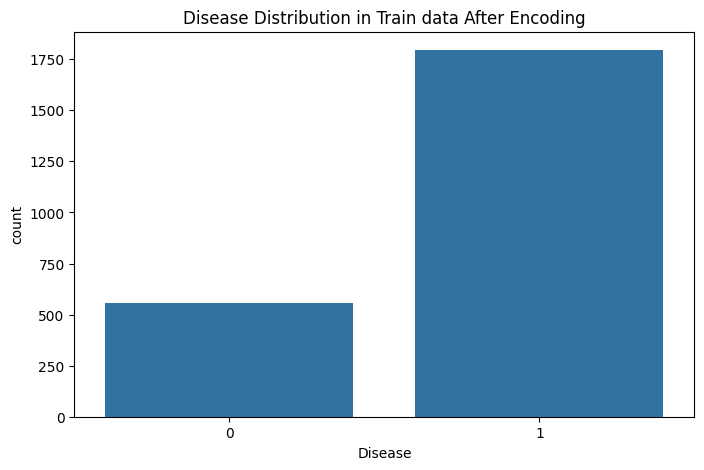

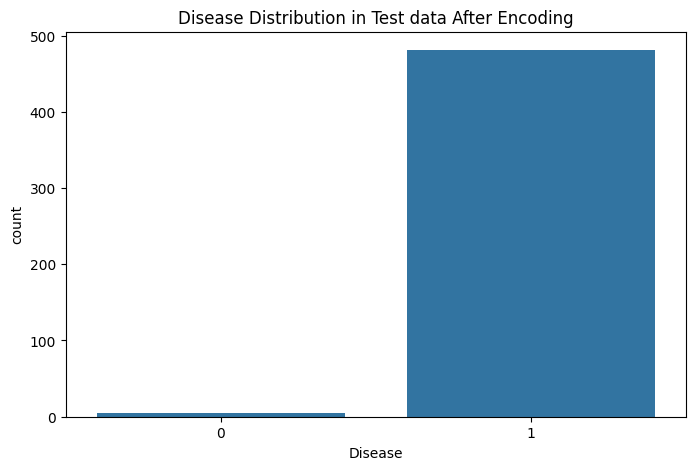

In [31]:
train_data = pd.read_csv('Train_data.csv')
test_data = pd.read_csv('test_data.csv')

print(train_data.shape)
print(test_data.shape)

print(train_data.iloc[1], '\n')
print(test_data.iloc[1])



plt.figure(figsize=(8,5))
sns.countplot(x='Disease', data=train_data)
plt.title('Disease Distribution in Train data Before Encoding')
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='Disease', data=test_data)
plt.title('Disease Distribution in Test data Before Encoding')
plt.show()


#Make the target column a numerical value
label_encoder = LabelEncoder()
train_data['Disease'] = train_data['Disease'].apply(lambda x: 0 if x == 'Healthy' else 1)
test_data['Disease'] = test_data['Disease'].apply(lambda x: 0 if x == 'Healthy' else 1)

plt.figure(figsize=(8,5))
sns.countplot(x='Disease', data=train_data)
plt.title('Disease Distribution in Train data After Encoding')
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='Disease', data=test_data)
plt.title('Disease Distribution in Test data After Encoding')
plt.show()

In [ ]:
# #Drop Duplicates

# train_dups = train_data.duplicated()
# print(f" Sum Of Dups: {train_dups.sum()}")
# X_train = train_data.drop_duplicates()
# print(X_train.shape)


 Sum Of Dups: 2286
(65, 25)


In [26]:
# Separate features and target
X_train = train_data.drop('Disease', axis=1)
y_train = train_data['Disease']
X_test = test_data.drop('Disease', axis=1)
y_test = test_data['Disease']


In [27]:
#Data Cleaning
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)
print(X_train.isnull().sum())
print(X_test.isnull().sum())

# print(f" Sum Of Dups: {X_train.duplicated().sum()}")
# print(f" Sum Of Dups: {X_test.duplicated().sum()}")
print("-" * 30)

#Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Glucose                                      0
Cholesterol                                  0
Hemoglobin                                   0
Platelets                                    0
White Blood Cells                            0
Red Blood Cells                              0
Hematocrit                                   0
Mean Corpuscular Volume                      0
Mean Corpuscular Hemoglobin                  0
Mean Corpuscular Hemoglobin Concentration    0
Insulin                                      0
BMI                                          0
Systolic Blood Pressure                      0
Diastolic Blood Pressure                     0
Triglycerides                                0
HbA1c                                        0
LDL Cholesterol                              0
HDL Cholesterol                              0
ALT                                          0
AST                                          0
Heart Rate                                   0
Creatinine   

In [28]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'],
        'class_weight': [None, 'balanced']
    },
    'Naive Bayes': {

    }
}

models = {
    'Logistic Regression' : LogisticRegression(max_iter= 5000),
    'SVM': SVC(),
    'Naive Bayes' : GaussianNB(),
}


best_models = {}

# Perform Grid Search CV for each model
for model_name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name],
                               scoring='f1_weighted', cv=5, n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")


Best parameters for Logistic Regression: {'C': 1, 'solver': 'saga'}
Best parameters for SVM: {'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Best parameters for Naive Bayes: {}


Logistic Regression Performance:
Accuracy: 0.67
F1 Score: 0.79
Precision: 0.99
Recall: 0.67


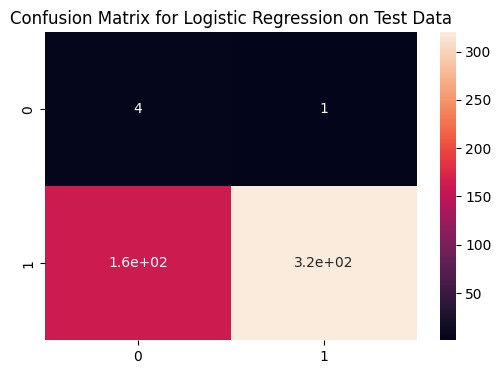

--------------------------------------------------
SVM Performance:
Accuracy: 0.95
F1 Score: 0.97
Precision: 0.98
Recall: 0.95


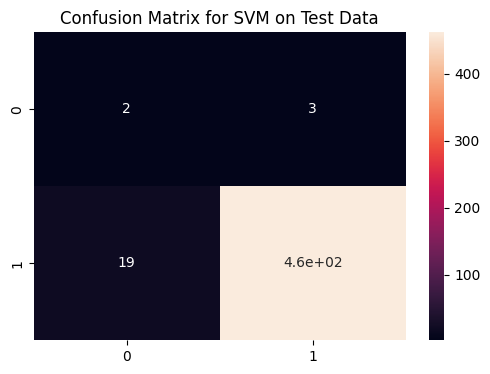

--------------------------------------------------
Naive Bayes Performance:
Accuracy: 0.85
F1 Score: 0.91
Precision: 0.99
Recall: 0.85


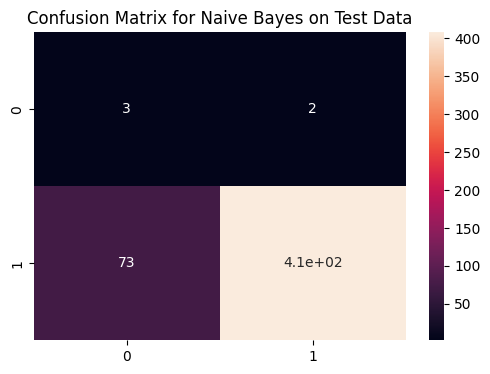

--------------------------------------------------

Best Model: SVM


In [29]:
results = []

for model_name, model in best_models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

    results.append((model_name, accuracy, f1, precision, recall, conf_matrix))

    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    plt.figure(figsize=(6,4))
    sns.heatmap(conf_matrix, annot=True)
    plt.title(f"Confusion Matrix for {model_name} on Test Data")
    plt.show()
    print('-' * 50)

best_model = max(results, key=lambda x: x[1])
print(f"\nBest Model: {best_model[0]}")